In [31]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd

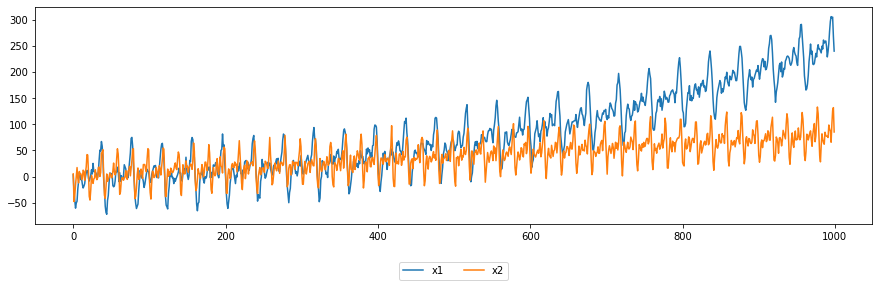

In [32]:
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)
# pattern + trend + noise
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [33]:
train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
print(train_len)

800


In [34]:
x_index = np.array(range(len(t)))
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)

[ 2.52235865e-04  7.38986691e-04 -1.55272844e+00]
[ 0.08024183 -0.81836002]


In [35]:
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

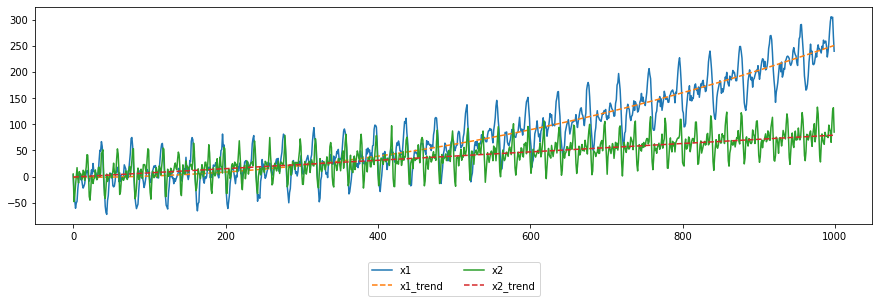

In [36]:
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

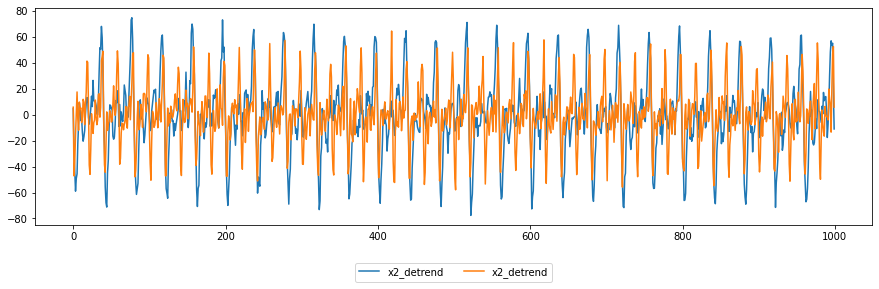

In [37]:
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [38]:
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1000, 4)
[[  4.8223907    5.83267252   0.           1.        ]
 [-28.73936096 -47.17107229   1.           1.        ]
 [-44.22063613 -35.7534276    2.           1.        ]
 ...
 [ 55.12195438  46.97392719 997.           0.        ]
 [ 18.02596882  52.57942224 998.           0.        ]
 [-10.97364808   5.8737469  999.           0.        ]]


In [39]:
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

[74.83253455041365, 64.56443297225348, 1, 1]


In [40]:
x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

[[ 6.44424345e-02  9.03387864e-02  0.00000000e+00  1.00000000e+00]
 [-3.84049012e-01 -7.30604609e-01  1.00000000e+00  1.00000000e+00]
 [-5.90927949e-01 -5.53763519e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 7.36604135e-01  7.27551146e-01  9.97000000e+02  0.00000000e+00]
 [ 2.40884114e-01  8.14371316e-01  9.98000000e+02  0.00000000e+00]
 [-1.46642742e-01  9.09749630e-02  9.99000000e+02  0.00000000e+00]]


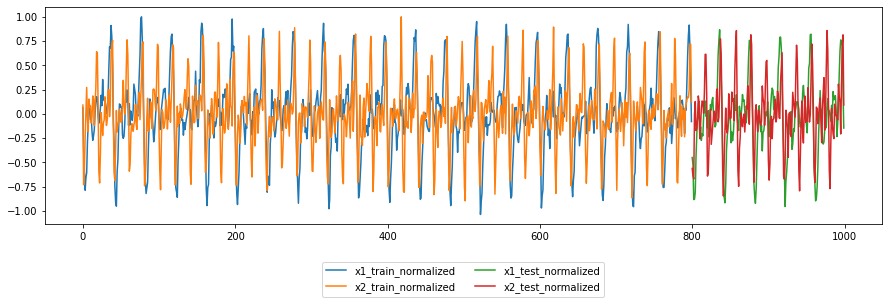

In [41]:
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [42]:
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 3) (781, 20, 3) (781,)


In [43]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


# Model 1: Simple Seq2Seq LSTM Model

In [44]:
n_hidden = 100

In [45]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 2), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


In [46]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_2/strided_slice_3:0', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_2/while:4', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_2/while:5', description="created by layer 'lstm_2'")


In [47]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [48]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_3/transpose_1:0', description="created by layer 'lstm_3'")


In [49]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


In [50]:
model = Model(inputs=input_train, outputs=out)
opt = keras.optimizers.adam_v2.Adam(learning_rate = 0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 2)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 100), (None, 41200       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 100)          400         lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 20, 100)      0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

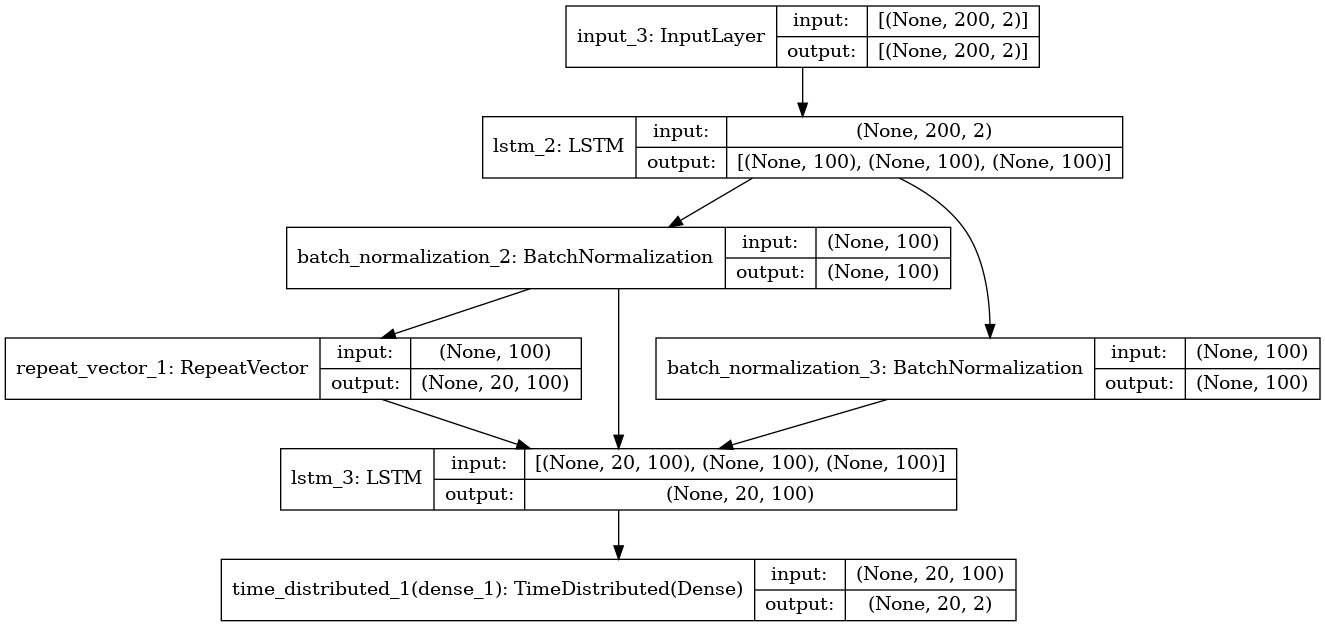

In [51]:
keras.utils.vis_utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [52]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
# model.save('model_forecasting_seq2seq.h5')

Epoch 1/100
5/5 [==============================] - 5s 402ms/step - loss: 3.9958 - mae: 1.0736 - val_loss: 0.1457 - val_mae: 0.2826
Epoch 2/100
5/5 [==============================] - 2s 320ms/step - loss: 0.2187 - mae: 0.3543 - val_loss: 0.1302 - val_mae: 0.2565
Epoch 3/100
5/5 [==============================] - 2s 326ms/step - loss: 0.1409 - mae: 0.2813 - val_loss: 0.1330 - val_mae: 0.2684
Epoch 4/100
5/5 [==============================] - 2s 335ms/step - loss: 0.1262 - mae: 0.2636 - val_loss: 0.1290 - val_mae: 0.2690
Epoch 5/100
5/5 [==============================] - 2s 334ms/step - loss: 0.1176 - mae: 0.2527 - val_loss: 0.1068 - val_mae: 0.2392
Epoch 6/100
5/5 [==============================] - 2s 311ms/step - loss: 0.1102 - mae: 0.2465 - val_loss: 0.1012 - val_mae: 0.2338
Epoch 7/100
5/5 [==============================] - 2s 304ms/step - loss: 0.1058 - mae: 0.2434 - val_loss: 0.0987 - val_mae: 0.2279
Epoch 8/100
5/5 [==============================] - 2s 306ms/step - loss: 0.1015 - m

5/5 [==============================] - 2s 312ms/step - loss: 0.0208 - mae: 0.1091 - val_loss: 0.0119 - val_mae: 0.0854
Epoch 64/100
5/5 [==============================] - 1s 300ms/step - loss: 0.0186 - mae: 0.1043 - val_loss: 0.0119 - val_mae: 0.0848
Epoch 65/100
5/5 [==============================] - 2s 308ms/step - loss: 0.0196 - mae: 0.1064 - val_loss: 0.0125 - val_mae: 0.0875
Epoch 66/100
5/5 [==============================] - 1s 301ms/step - loss: 0.0223 - mae: 0.1116 - val_loss: 0.0159 - val_mae: 0.0987
Epoch 67/100
5/5 [==============================] - 1s 300ms/step - loss: 0.0252 - mae: 0.1188 - val_loss: 0.0172 - val_mae: 0.1013
Epoch 68/100
5/5 [==============================] - 1s 292ms/step - loss: 0.0223 - mae: 0.1121 - val_loss: 0.0187 - val_mae: 0.1054
Epoch 69/100
5/5 [==============================] - 1s 303ms/step - loss: 0.0219 - mae: 0.1119 - val_loss: 0.0133 - val_mae: 0.0889
Epoch 70/100
5/5 [==============================] - 1s 302ms/step - loss: 0.0234 - mae: 0

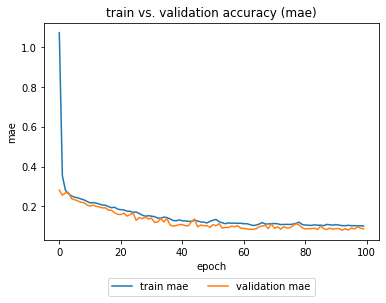

In [53]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [54]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


In [55]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


In [56]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


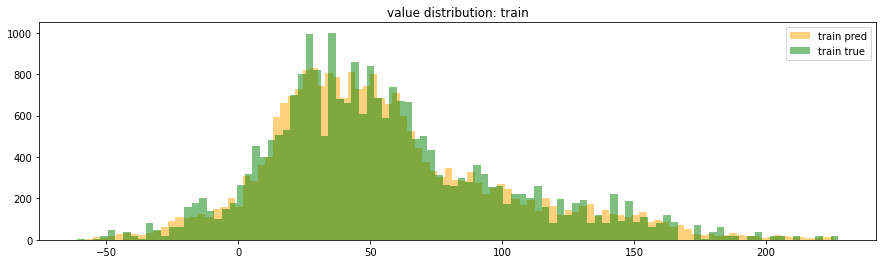

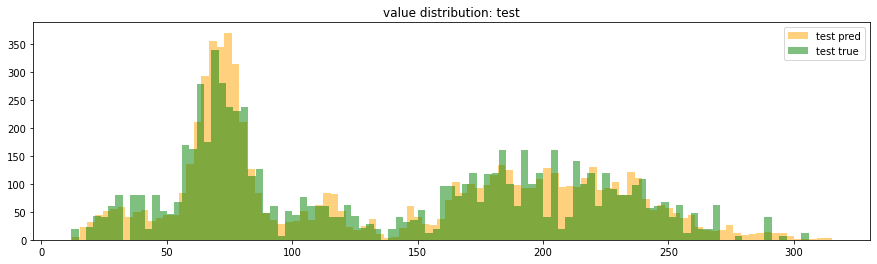

In [57]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

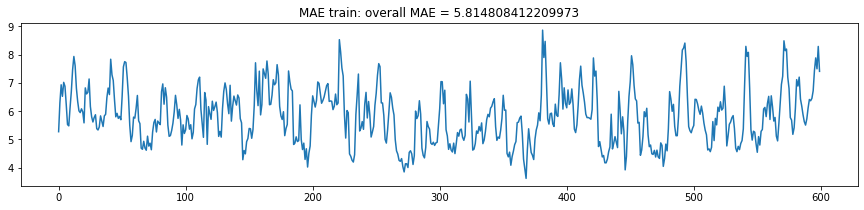

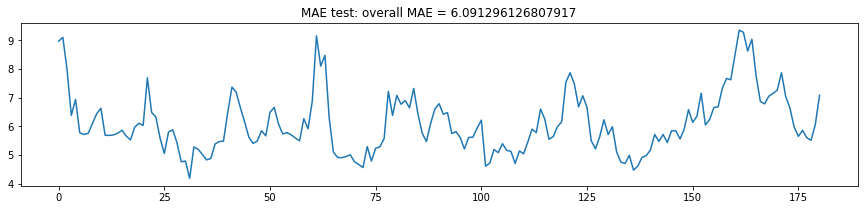

In [58]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

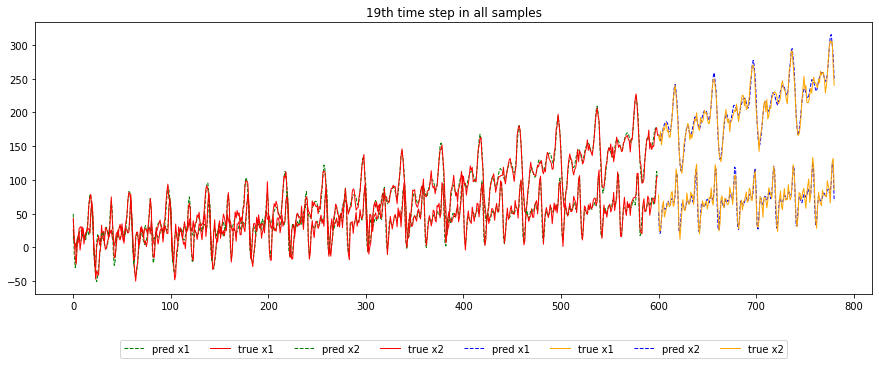

In [59]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

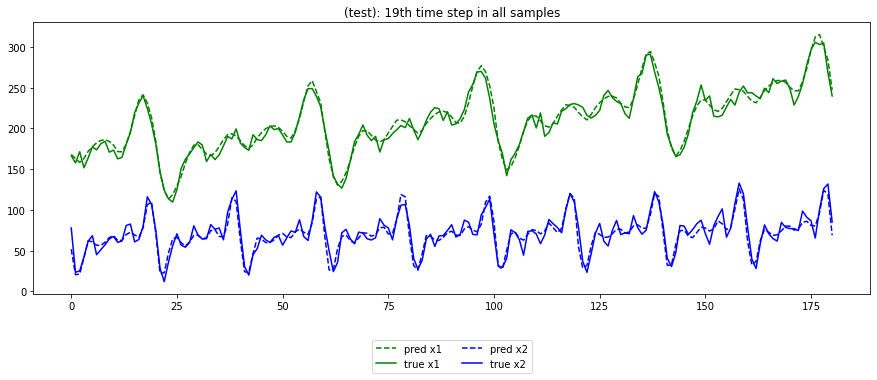

In [60]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# Model 2: Seq2Seq LSTM Model with Luong Attention

In [61]:
n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

In [62]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 100), dtype=tf.float32, name=None), name='lstm_4/transpose_1:0', description="created by layer 'lstm_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_4/while:4', description="created by layer 'lstm_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_4/while:5', description="created by layer 'lstm_4'")


In [63]:
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [64]:
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='repeat_vector_2/Tile:0', description="created by layer 'repeat_vector_2'")


In [65]:
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_5/transpose_1:0', description="created by layer 'lstm_5'")


In [66]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


In [67]:
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='batch_normalization_6/batchnorm/add_1:0', description="created by layer 'batch_normalization_6'")


In [69]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")


In [70]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed_2/Reshape_1:0', description="created by layer 'time_distributed_2'")


In [72]:
model = Model(inputs=input_train, outputs=out)
opt = keras.optimizers.adam_v2.Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200, 2)]     0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 200, 100), ( 41200       input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 100)          400         lstm_4[0][1]                     
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 20, 100)      0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

/home/valdo/.virtualenvs/seq2seq-2cC7ZY1Q/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


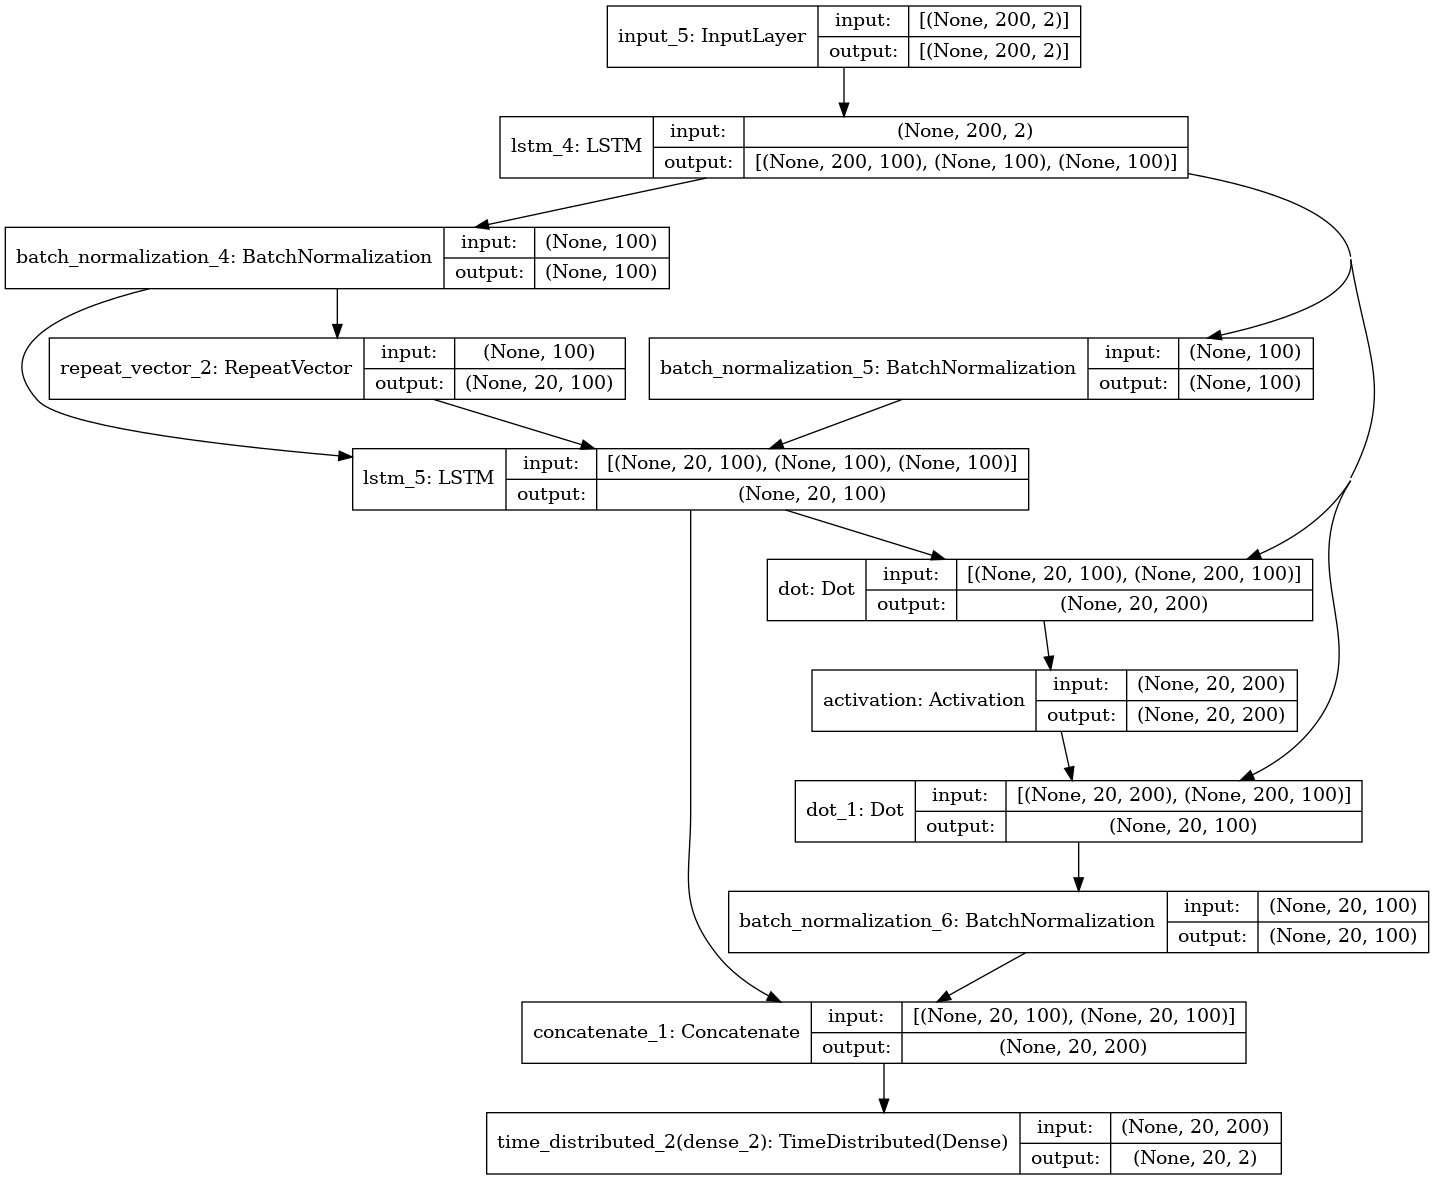

In [73]:
keras.utils.vis_utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [74]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
# model.save('model_forecasting_seq2seq.h5')

Epoch 1/100
5/5 [==============================] - 6s 505ms/step - loss: 17.8414 - mae: 1.4664 - val_loss: 0.1555 - val_mae: 0.3014
Epoch 2/100
5/5 [==============================] - 2s 386ms/step - loss: 0.2233 - mae: 0.3439 - val_loss: 0.5281 - val_mae: 0.6471
Epoch 3/100
5/5 [==============================] - 2s 424ms/step - loss: 0.1342 - mae: 0.2754 - val_loss: 0.2109 - val_mae: 0.3804
Epoch 4/100
5/5 [==============================] - 2s 401ms/step - loss: 0.1229 - mae: 0.2611 - val_loss: 0.1770 - val_mae: 0.3501
Epoch 5/100
5/5 [==============================] - 2s 385ms/step - loss: 0.1150 - mae: 0.2500 - val_loss: 0.1316 - val_mae: 0.2832
Epoch 6/100
5/5 [==============================] - 2s 398ms/step - loss: 0.1061 - mae: 0.2428 - val_loss: 0.1060 - val_mae: 0.2484
Epoch 7/100
5/5 [==============================] - 2s 401ms/step - loss: 0.1012 - mae: 0.2387 - val_loss: 0.0940 - val_mae: 0.2292
Epoch 8/100
5/5 [==============================] - 2s 402ms/step - loss: 0.0979 - 

5/5 [==============================] - 2s 398ms/step - loss: 0.0212 - mae: 0.1094 - val_loss: 0.0126 - val_mae: 0.0894
Epoch 64/100
5/5 [==============================] - 2s 397ms/step - loss: 0.0207 - mae: 0.1083 - val_loss: 0.0127 - val_mae: 0.0887
Epoch 65/100
5/5 [==============================] - 2s 398ms/step - loss: 0.0201 - mae: 0.1074 - val_loss: 0.0121 - val_mae: 0.0869
Epoch 66/100
5/5 [==============================] - 2s 399ms/step - loss: 0.0204 - mae: 0.1077 - val_loss: 0.0126 - val_mae: 0.0868
Epoch 67/100
5/5 [==============================] - 2s 409ms/step - loss: 0.0233 - mae: 0.1129 - val_loss: 0.0182 - val_mae: 0.1032
Epoch 68/100
5/5 [==============================] - 2s 396ms/step - loss: 0.0218 - mae: 0.1121 - val_loss: 0.0197 - val_mae: 0.1032
Epoch 69/100
5/5 [==============================] - 2s 396ms/step - loss: 0.0264 - mae: 0.1203 - val_loss: 0.0156 - val_mae: 0.0958
Epoch 70/100
5/5 [==============================] - 2s 398ms/step - loss: 0.0195 - mae: 0

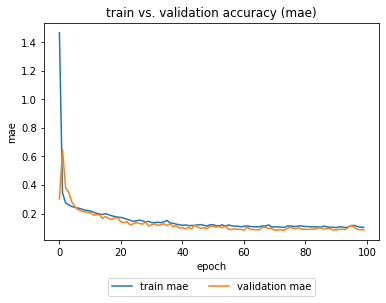

In [75]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [76]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


In [77]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


In [78]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


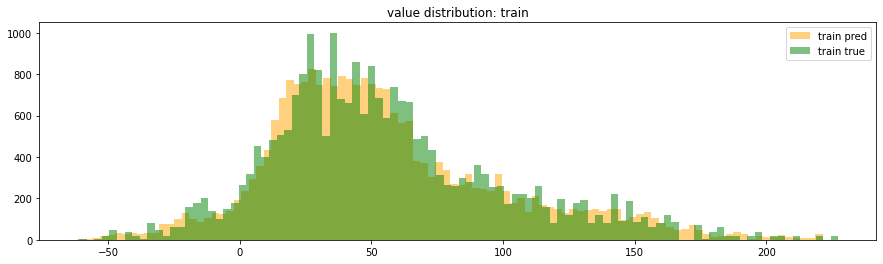

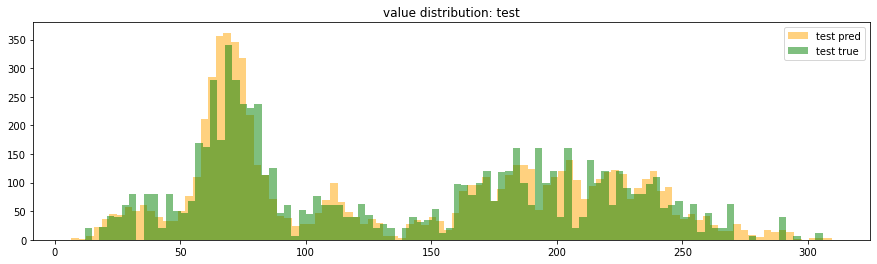

In [79]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

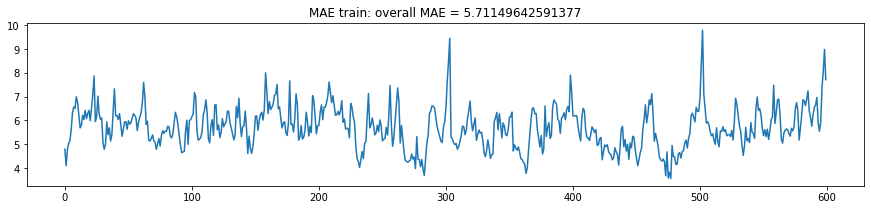

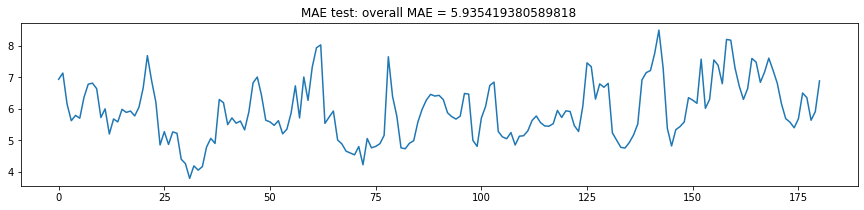

In [80]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

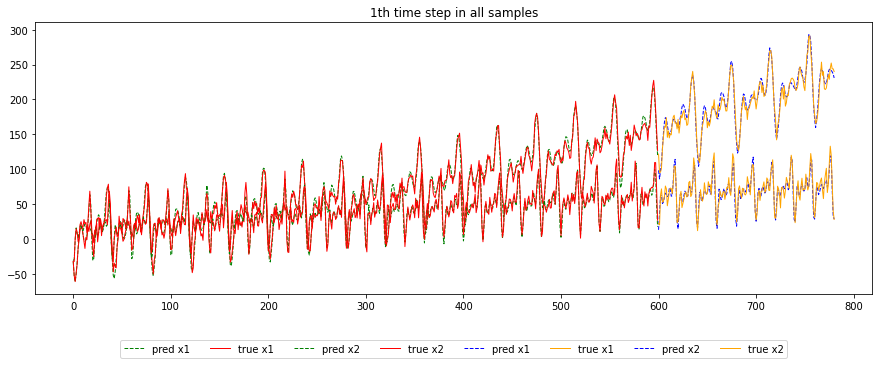

In [81]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

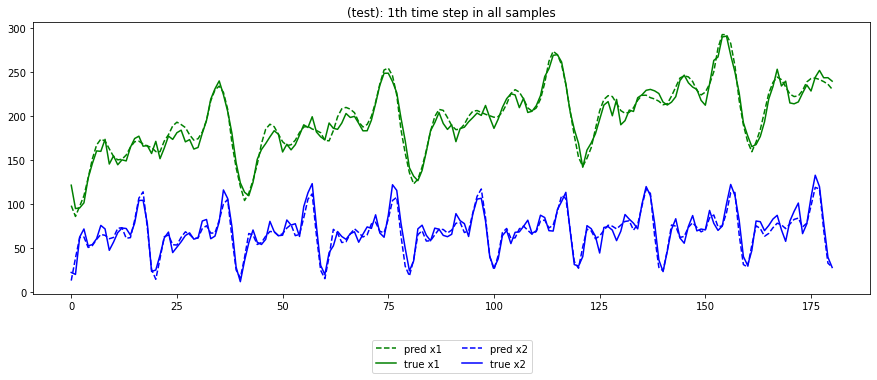

In [82]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()